# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"
star_file = "Projections/crossvalidation1/crossvalidation1.star"
#star_file = "Projections/crossvalidation1_zeros/crossvalidation1_zeros.star"
#star_file = "particles_crossvalidation_test_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [ ]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()



In [ ]:
N = imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

#file2 = open(out_dir + '/idxrand','wb')
#pickle.dump(idxrand, file2)
#file2.close()

In [ ]:
idx =123
plt.imshow(imgs0[idx]);plt.colorbar()

In [ ]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
#imgs0_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

print(time.time()-t0)

In [ ]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

### Crop images

In [22]:
nx = 128 #64
x_grid_nx0 = x_grid
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid_nx0, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)



[2.38549618e-03 1.28000000e+02]


In [23]:
imgs_f = imgs_f.reshape(N,-1)
print(imgs_f.shape)

(26380, 16384)


### More processing

Text(0.5, 1.0, 'Estimated noise')

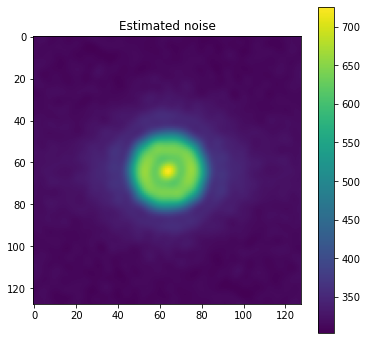

In [16]:
N_noise = 48
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

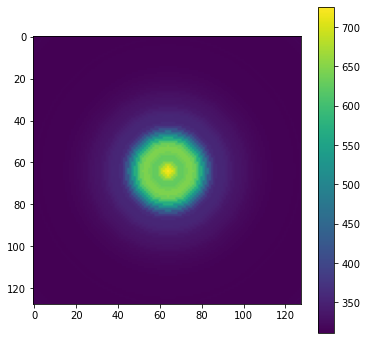

In [17]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [18]:
sigma_noise = sigma_noise_avg.reshape(-1)

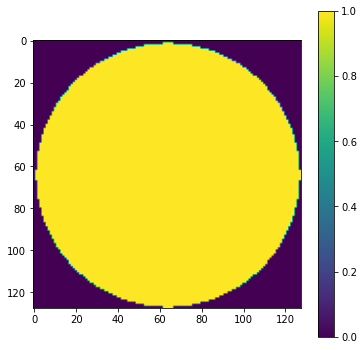

In [19]:
radius = 0.074 * 2.032
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Get residual

In [24]:
N_batches = 600 # for full dataset and 64

vol, vol_sigma, vol_counts = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 21.825079202651978 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 4.635340690612793 seconds.
Batch 10, 0.04052734375 seconds.
Batch 20, 0.04026675224304199 seconds.
Batch 30, 0.04041624069213867 seconds.
Batch 40, 0.04113650321960449 seconds.
Batch 50, 0.03996634483337402 seconds.
Batch 60, 0.039603233337402344 seconds.
Batch 70, 0.041634321212768555 seconds.
Batch 80, 0.04011821746826172 seconds.
Batch 90, 0.04004955291748047 seconds.
Batch 100, 0.03993964195251465 seconds.
Batch 110, 0.04104924201965332 seconds.
Batch 120, 0.04102635383605957 seconds.
Batch 130, 0.03996133804321289 seconds.
Batch 140, 0.04030871391296387 seconds.
Batch 150, 0.04429268836975098 seconds.
Batch 160, 0.04051375389099121 seconds.
Batch 170, 0.039285898208618164 seconds.
Batch 180, 0.04048585891723633 seconds.
Batch 190, 0.039682626724243164 seconds.
Batch 200, 0.04030942916870117 seconds.

In [33]:
vol0, vol0_sigma, vol0_counts = get_volume_residual(jnp.abs(imgs0_f), angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 19.606279611587524 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.5334970951080322 seconds.
Batch 10, 0.03874707221984863 seconds.
Batch 20, 0.03918313980102539 seconds.
Batch 30, 0.04102063179016113 seconds.
Batch 40, 0.03888344764709473 seconds.
Batch 50, 0.03871870040893555 seconds.
Batch 60, 0.03895282745361328 seconds.
Batch 70, 0.03905653953552246 seconds.
Batch 80, 0.039167165756225586 seconds.
Batch 90, 0.03887820243835449 seconds.
Batch 100, 0.03859376907348633 seconds.
Batch 110, 0.03895092010498047 seconds.
Batch 120, 0.03957676887512207 seconds.
Batch 130, 0.03873872756958008 seconds.
Batch 140, 0.03902125358581543 seconds.
Batch 150, 0.03940892219543457 seconds.
Batch 160, 0.0393824577331543 seconds.
Batch 170, 0.042903900146484375 seconds.
Batch 180, 0.03877568244934082 seconds.
Batch 190, 0.038956642150878906 seconds.
Batch 200, 0.03924918174743652 sec

In [26]:
vold, vold_sigma, vold_counts = get_volume_residual(jnp.abs(imgs_f-imgs0_f), angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 20.218420267105103 seconds.
Average residuals in each voxel. 329354300 residuals in 600 batches.
Batch 0, 0.6910216808319092 seconds.
Batch 10, 0.039392709732055664 seconds.
Batch 20, 0.039270877838134766 seconds.
Batch 30, 0.03950309753417969 seconds.
Batch 40, 0.039017677307128906 seconds.
Batch 50, 0.03926658630371094 seconds.
Batch 60, 0.03873443603515625 seconds.
Batch 70, 0.039263010025024414 seconds.
Batch 80, 0.03908991813659668 seconds.
Batch 90, 0.03877878189086914 seconds.
Batch 100, 0.0386660099029541 seconds.
Batch 110, 0.04196429252624512 seconds.
Batch 120, 0.039426326751708984 seconds.
Batch 130, 0.03926897048950195 seconds.
Batch 140, 0.04100537300109863 seconds.
Batch 150, 0.03891706466674805 seconds.
Batch 160, 0.03899240493774414 seconds.
Batch 170, 0.039479732513427734 seconds.
Batch 180, 0.03915715217590332 seconds.
Batch 190, 0.04610490798950195 seconds.
Batch 200, 0.03907585144042969 

In [39]:
print(jnp.real(jnp.max(vold)))
print(jnp.real(jnp.max(vol0)))

803.662353515625
913.9186127661757


In [72]:
resid_abs = jnp.real(jnp.fft.fftshift(vold))
resid0_abs = jnp.real(jnp.fft.fftshift(vol0))
resid_sig_abs = jnp.real(jnp.fft.fftshift(vold/(vol0_sigma+1)))
resid0_sig_abs = jnp.real(jnp.fft.fftshift(vol0/(vol0_sigma+1)))

In [73]:
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid_abs.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid0_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0_abs.astype(np.float32))
    
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid_sig_abs.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids_abs/resid0_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0_sig_abs.astype(np.float32))

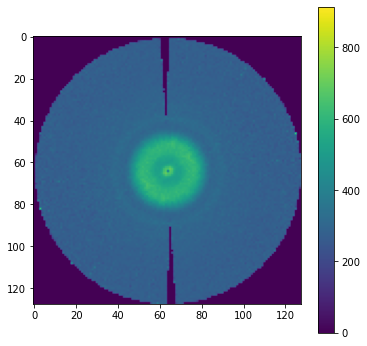

In [62]:
plt.imshow(resid_abs, vmax=914); plt.colorbar()

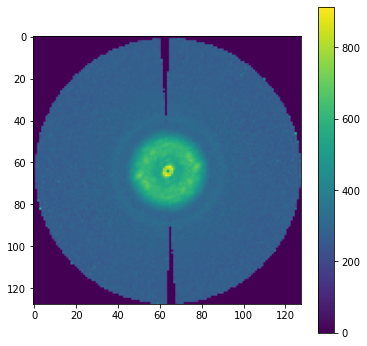

In [63]:
plt.imshow(resid0_abs, vmax=914); plt.colorbar()

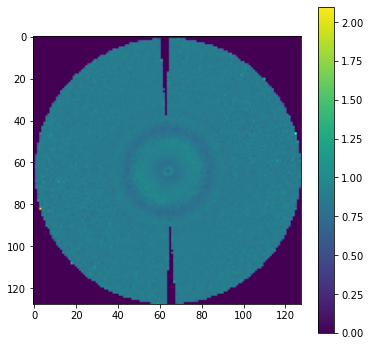

In [64]:
plt.imshow(resid_sig_abs); plt.colorbar()

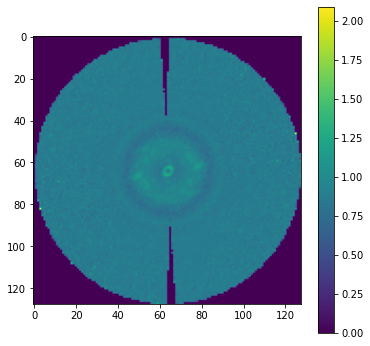

In [65]:
plt.imshow(resid0_sig_abs); plt.colorbar()

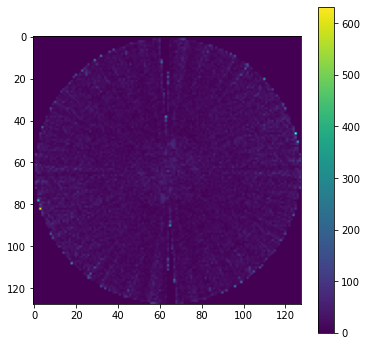

In [31]:
plt.imshow(jnp.abs(jnp.fft.fftshift((vol0[0]-vol[0])))); plt.colorbar()

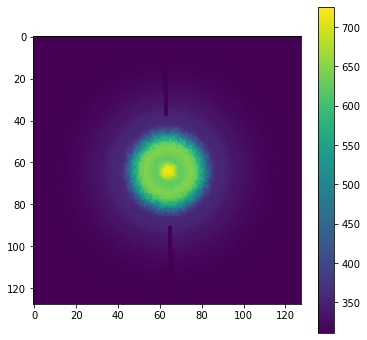

In [29]:
plt.imshow(jnp.fft.fftshift(vol_sigma[0]), vmin=jnp.min(sigma_noise_avg)); plt.colorbar()

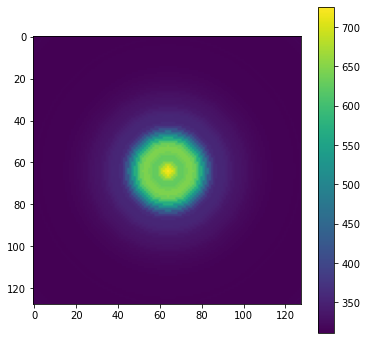

In [30]:
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

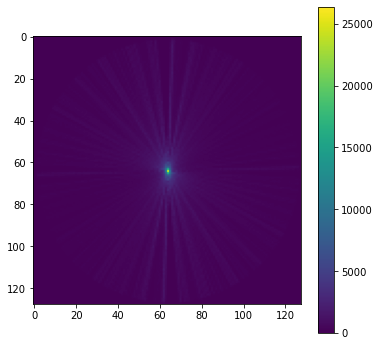

In [221]:
plt.imshow(jnp.fft.fftshift(vol_counts[0])); plt.colorbar()

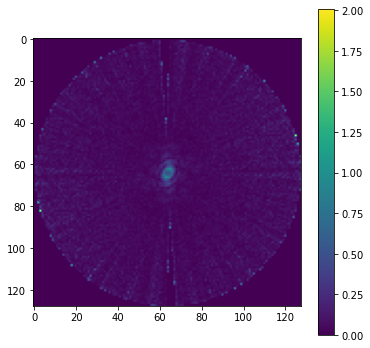

In [222]:
vs = vol/(vol_sigma+1e-16)

plt.imshow(jnp.abs(jnp.fft.fftshift(vs[0]))); plt.colorbar()

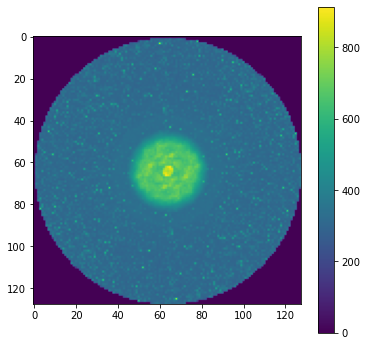

In [35]:
mip_x(jnp.abs(jnp.fft.fftshift(vol0))); plt.colorbar()

In [179]:
N = 10
A = jnp.zeros([N, N, N])
#A = A.at[0,0,0].set(2000)
#A = A.at[0,0,1].set(3000)

In [180]:
x = jnp.array([0,0,0])
y = jnp.array([0,0,0])
z = jnp.array([0,1,1])

xyz = jnp.ravel_multi_index((x,y,z), dims = A.shape)

In [181]:
B = A.reshape(-1).at[xyz].set([8880,9990, 3]).reshape([N,N,N])

In [73]:
@jax.jit
def myfunc(B):
    return jnp.matmul(A, B)

In [83]:
myfunc2 = jax.jit(lambda C : jnp.matmul(A, C))

In [81]:
t0 = time.time()
bb = myfunc(B)
bb.block_until_ready()
print(time.time()-t0)

0.30991482734680176


In [89]:
t0 = time.time()
bb = myfunc2(B)
bb.block_until_ready()
print(time.time()-t0)

0.3027036190032959


In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid3[0]))); plt.colorbar()

NameError: name 'v_resid3' is not defined

In [208]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

NameError: name 'v_resid' is not defined

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/cryodrgn_crossvalidation/v_resid_cv2_128.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [45]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_64.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_64_proj.mrc').data

In [36]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(5041074., dtype=float32)

In [25]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_128.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_128.mrc').data


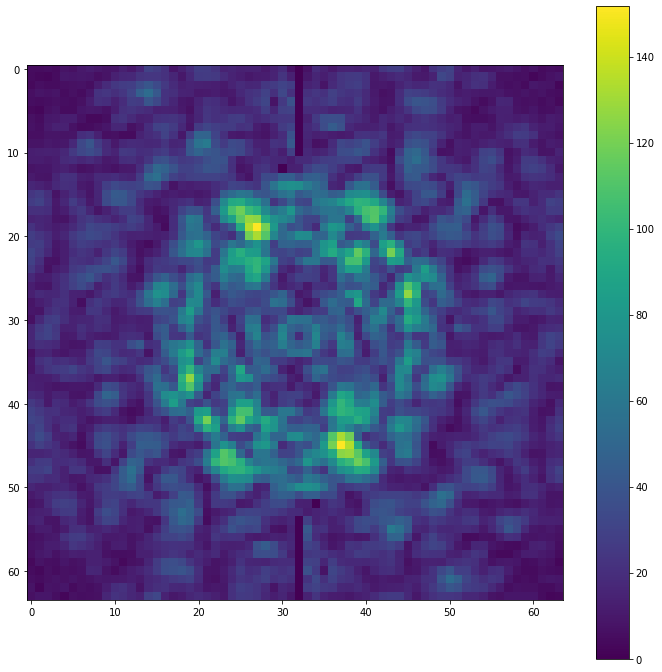

In [49]:
plt.imshow(rv[:,:,32]); plt.colorbar()

In [32]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(0., dtype=float32)

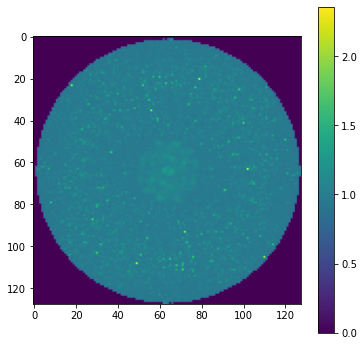

In [30]:
mip_z(rv); plt.colorbar()

### Read the Fourier volumes

In [306]:
cvidx = 1

In [309]:
with open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_proj_{nx}", 'rb') as file:
    # Call load method to deserialze
    proj = pickle.load(file)

with open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_img_{nx}", 'rb') as file:
    # Call load method to deserialze
    img_vol = pickle.load(file)
    
sigma_vol = mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_img_{nx}_sigma.mrc").data
vol_counts = mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_img_{nx}_counts.mrc").data
vol_counts2 = mrcfile.open(f"../data/cryodrgn_crossvalidation/cv{cvidx}_relion_proj_{nx}_counts.mrc").data


In [310]:
resid = jnp.fft.fftshift(jnp.abs(img_vol-proj))
resid0 = jnp.fft.fftshift(jnp.abs(img_vol))
resid_sig = resid/(sigma_vol+1)
resid0_sig = resid0/(sigma_vol+1)

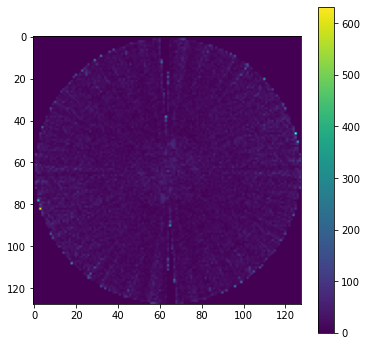

In [364]:
plt.imshow(resid[64]); plt.colorbar()

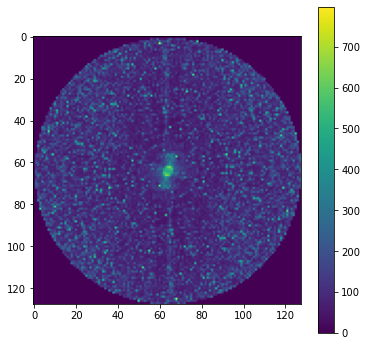

In [313]:
mip_x(resid0); plt.colorbar()

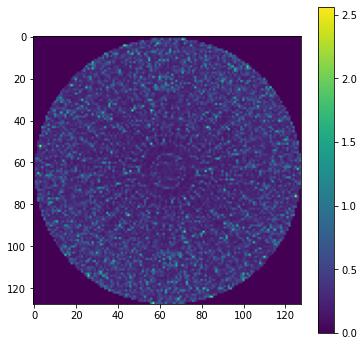

In [314]:
mip_z(resid_sig); plt.colorbar()

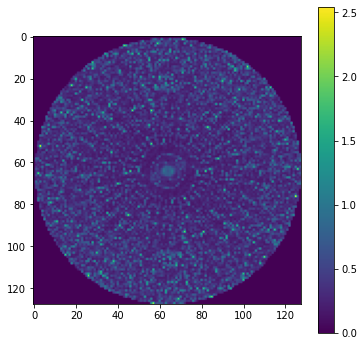

In [315]:
mip_z(resid0_sig); plt.colorbar()

In [316]:
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids/resid_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids/resid0_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0.astype(np.float32))
    
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids/resid_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid_sig.astype(np.float32))
with mrcfile.new(f"../data/cryodrgn_crossvalidation/resids/resid0_sig_cv{cvidx}_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(resid0_sig.astype(np.float32))